# *Vinho Verde* wine quality project

## Table of contents

### 1. Data quality check
* Libraries import and default configuration.
* Data load, inspection and target feature creation.

### 2. Descriptive statistics
* General overview.
* Target feature distribution.
* Correlation matrix.

### 3. Exporatory data analysis
* Features statistics per target label.
* Correlated features analysis.

### 4. Data pre-processing
* Train/test split, normalization and resample of the data.

### 5. Model development
* Model selection and baselines.
* Model tunning.
* Model validation.
* Feature importance and predictions.

In [1]:
__author__ = "Juan Vicente Peluso"
__email__ = "vpeluso@gmail.com"

## 1. Data quality check and target feature creation

* **Libraries import and default configurations**

In [2]:
# Import necessary libraries
import os
import itertools
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SVMSMOTE 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

# Ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings('ignore')

# Default configurations (Pandas and colors for the graphs)
sns.set(style = 'white')
rndSt = 14
pd.set_option('display.max_columns', 500)
CorrCmap = sns.diverging_palette(10, 240, as_cmap=True)
plotColor = ['b','g','r','m','c', 'y']
scatColor = [['#0099ff','#002db3'], ['#1aff1a','#00b33c'],
             ['#ff8080','#ff0000'], ['#e066ff','#8600b3']]
print('Libraries imported and default configurations set.')

Libraries imported and default configurations set.


* **Classes definition**

To see the classes documentation, please click [here](myData/classHelp.txt)

In [3]:
class dataHandler():

    """ Class that load files, check it, and work with it """

    def __init__(self, dataFile, targCol = '', printI = True):
        self.dataFile = dataFile
        self.targCol = targCol
        self.printI = printI

    def allTasks(self):
        
        ''' Load data and runs data integrity processes '''
        
        self.oldDF = self.loadCsv(self.dataFile)
        print('File loaded in dataframe')
        self.newDF = self.createTarg()
        self.trainX = pd.DataFrame()
        self.testX = pd.DataFrame()
        self.trainY = pd.DataFrame()
        self.testY = pd.DataFrame()
        self.trainX_N = pd.DataFrame()
        self.testX_N = pd.DataFrame()
        self.trainX_NS = pd.DataFrame()
        self.testX_NS = pd.DataFrame()
        self.trainY_NS = pd.DataFrame()
        self.predFile = 'myData/wineQualPred.xlsx'
        print('New target label created')
        self.renameCols()
        print('Columns renamed\n\n### Checking dataframe ###\n')
        self.checkAll(self.newDF, Del = True, printI = self.printI)
    
    def createTarg(self):
        
        ''' Creates the new target feature '''
        
        df = self.oldDF.copy()
        df[self.targCol] = pd.cut(df[self.targCol],bins = [0,6.5,11], labels = [0, 1])
        df[self.targCol] = pd.to_numeric(df[self.targCol])
        return df
    
    def loadCsv(self, fileName):
        df = pd.read_csv(fileName)
        return df

    def checkAll(self, df, Del = False, printI = False):
        
        ''' Check data integrity '''
        
        try:
            if isinstance(df, pd.DataFrame) : DF = df
        except:
            print('The file recieved isn\'t a Pandas Dataframe')

        if printI : self.printInfo(DF)
        self.printShape(DF)
        self.checkNaN(DF, Del)
        self.checkDup(DF)

    def printShape(self, df):
        print('Dataframe shape\n---------------')
        print('{}\n'.format(df.shape))

    def printInfo(self, df):
        print('Dataframe information\n---------------------')
        print('{}\n'.format(df.info()))

    def checkNaN(self, df, Del = False):
        nan = np.sum(df.isna().sum())
        print('NaN values\n----------')
        if nan > 0:
            if Del:
                df.dropna()
                print('{} rows with NaN values\nNaN rows successfully deleted\n'.format(nan))
            else : print('{} rows with NaN values\n'.format(nan))
        else : print('{} rows with NaN values\n'.format(nan))


    def checkDup(self, df, Del = False):
        dup = df.duplicated().sum()
        print('Duplicated rows\n---------------')
        if dup > 0:
            if Del:
                df.drop_duplicates()
                print('{} duplicated rows\nDuplicated rows successfully deleted\n'.format(dup))
            else : print('{} duplicated rows\n'.format(dup))
        else : print('{} duplicated rows\n'.format(dup))

    def renameCols(self):
        
        self.newDF = self.newDF.rename(columns={'fixed acidity':'Fixed acidity',
                                                'free sulfur dioxide':'Free so2',
                                                'volatile acidity':'Volatile acidity',
                                                'citric acid':'Citric acid', 
                                                'residual sugar':'Residual sugar',
                                                'chlorides':'Chlorides', 
                                                'total sulfur dioxide':'Total so2',
                                                'density':'Density', 'alcohol':'Alcohol',
                                                'sulphates':'Sulphates','quality' : 'Quality'})
        
    def outliersC(self):
        
        ''' Process that check for outliers '''
        
        lstResults = []
        lstColumns = ['Feature', 'Lower outliers', 'Upper outliers', 'Lower outliers pct', 
                      'Upper outliers pct']
        tmpDF = self.newDF.describe()
        for feature in list(tmpDF.columns)[0:11]:
            IQR = [tmpDF.loc['25%', feature], tmpDF.loc['75%', feature]]
            lowCount = self.newDF[self.newDF[feature] < ((IQR[0] - (IQR[1]-IQR[0])*1.5))].count()[0]
            highCount = self.newDF[self.newDF[feature] > ((IQR[1] + (IQR[1]-IQR[0])*1.5))].count()[0]
            lowPerc = (lowCount/self.newDF.shape[0])*100
            highPerc = (highCount/self.newDF.shape[0])*100
            lstResults.append([feature, lowCount, highCount, lowPerc, highPerc])
        df = pd.DataFrame(lstResults, columns = lstColumns).set_index('Feature')
        return df
    
    def splitTrainTest(self, X,y,size,strat):
        trX,trY,tsX,tsY = train_test_split(X, y, test_size=size, random_state=rndSt, stratify=strat)
        print('Data splitted in train and test datasets\n')
        print('====================================')
        print('Full dataset shape   --> ', self.newDF.shape)
        print('Train features shape --> ', trX.shape)
        print('Test features shape  --> ', tsX.shape)
        print('Train target shape   --> ', trY.shape)
        print('Test target shape    --> ', tsY.shape,)
        print('====================================\n')
        return trX,trY,tsX,tsY
    
    def groupDF(self, col, method = 'mean'):
        
        ''' Returns the DF statistical info selected '''
        
        summaryDF = self.newDF.groupby(col)
        if method == 'mean' : return summaryDF.mean()
        if method == 'std' : return summaryDF.std()
        if method == 'min' : return summaryDF.min()
        if method == 'max' : return summaryDF.max()
        
    def aggData(self, df, group, agg, aggM, sort = '', sortL = [], asc = True):
        
        ''' Aggregate data and return it '''
        
        DF = df.groupby(group).agg({agg : aggM}).reset_index()
        if len(sort)>0 : DF.sort_values(by=sort, ascending=asc, inplace=True)
        if len(sortL)>0 : DF.sort_values(by=sortL, ascending=asc, inplace=True)
        return DF
    
    def dataPrep(self, feat, targ, TTsplit, strat):
        
        ''' Preprocess data for modeling '''
        
        self.trainX, self.testX, self.trainY, self.testY = self.splitTrainTest(self.newDF[feat],
                                                                               self.newDF[targ], TTsplit, 
                                                                               self.newDF[targ])
        self.trainX_N, self.testX_N = self.normalize(self.trainX, self.testX, feat)
        self.trainX_NS, self.trainY_NS = self.resample(self.trainX_N, self.trainY, True)
    
    def normalize(self, trDF, tsDF, cols):
        
        ''' Normalize (StandardScaler) data '''
        
        scaler = StandardScaler()
        trDF_N = pd.DataFrame(scaler.fit_transform(trDF), columns = cols, 
                              index = trDF.index)
        tsDF_N = pd.DataFrame(scaler.transform(tsDF), columns = cols, 
                              index =tsDF.index)
        print('Data normalized\n')
        return (trDF_N, tsDF_N)
    
    def resample(self, dfX, dfY, End = False):
        
        ''' Resample data using SMOTE '''
        
        SMT = SVMSMOTE(random_state = rndSt)
        dfXS, dfYS = SMT.fit_sample(dfX, dfY)
        if End:
            print('Data upsampled\n')
            print('===================================')
            print("Original shape: ", self.trainX.shape, data.trainY.shape)
            print("SMOTE shape:    ", dfXS.shape, dfYS.shape)
            print('===================================')
        return dfXS, dfYS

In [2]:
class plotGraph:
    
    def __init__(self):
        self.setStyle()

    def setStyle(self, style = 'white'):
        sns.set(style = style)
    
    def plotBarText(self, df, fig, title, xLabel, xTicks, xLabelFS = 10,
                    xTicksFS = 10, plotC = 'b', barW = 0.65, barTxtFS = 10):
        
        ''' Process that draw a tunned bar plot with text above the bars '''
        
        _ = plt.bar(xTicks, df.iloc[:, 1], width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 14, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS)
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'

            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)

    def plotCorr(self, corr, title, figSize = [5,5], titleFS = 15, cmap = 'blues', annot = True, 
                square = True, fmt = '.2f', vMM = [-1,1], lineW = 0.25, cbarD = {}, rot = 90,
                annD = {}, ticksFS = 10, yLim = [0.0,0.0]):
        
        ''' Process that plot a correlation matrix '''

        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        f, ax = plt.subplots(figsize=(figSize))
        ax.set_title(title, fontdict={'fontsize': titleFS})
        sns.heatmap(corr, annot = annot, mask=mask, cmap=cmap, vmin=vMM[0], vmax=vMM[1],
                    center=0, fmt=fmt, annot_kws=annD, square=True, linewidths=lineW, 
                    cbar_kws=cbarD)
        plt.xticks(fontsize = ticksFS, rotation = rot, ha = 'right')
        plt.yticks(fontsize = ticksFS)
        plt.title(title, fontsize = titleFS)
        b,t = plt.ylim()
        plt.ylim(bottom=(b*yLim[0]), top = (t*yLim[1]))
        
    def plotKDE(self, fig, title, kde, featureD, labels, 
                colors = ['b', 'g'], legLoc = 0, legFS = 12, titleFS = 15):
        
        ''' Process that draw KDE plots '''
        
        ax=sns.kdeplot(kde[0], color=colors[0], shade=True, label= labels[0])
        ax=sns.kdeplot(kde[1], color=colors[1], shade=True, label= labels[1])
        plt.title('{} {}'.format(featureD, title), fontsize = titleFS)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        if legLoc == 0 :
            plt.legend(frameon=False, loc = legLoc, fontsize = legFS)
        else :    
            plt.legend(frameon=False, bbox_to_anchor=(legLoc), fontsize = legFS)
        plt.tight_layout()
        
    def plotViolin(self, fig, X, y, plotC, title, xTicks, titleFS = 15,
                   xTicksFS = 10, inner = 'box'):
        
        ''' Process that draw violin plots '''
        
        ax = sns.violinplot(x = X, y = y, palette = plotC,  inner = inner)
        plt.tick_params(top=False, bottom=False, left=True, right=False)
        plt.title(title, fontsize = titleFS)
        ax.set_xticklabels(xTicks, fontsize = xTicksFS)
        ax.set_xlabel('')
        ax.set_ylabel('')
        for spine in plt.gca().spines.values():
            spine.set_visible(False) 
        plt.tight_layout()
        
    def plotScat(self, df, X, y, colHue, colStyle, palette, fig, markers, legLbl,
                 legLoc = 1, s = 25, yLblCo = [-0.105, 0.5], lblFS = 12, titleFS = 13):
        
        ''' Process that draw scatter plots '''
        
        sctPlot = sns.scatterplot(df[X], df[y], hue = df[colHue],  style = df[colStyle],
                                  palette = palette, markers=markers, s = s)
        sctTitle = X +' vs. ' + y
        sctPlot.yaxis.set_label_coords(yLblCo[0], yLblCo[1])
        plt.xlabel(X, fontSize = lblFS)
        plt.ylabel(y, fontSize = lblFS)
        sctPlot.set_title(sctTitle, fontsize = titleFS, y = 0.905, fontweight = 548)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        plt.legend(loc=legLoc) 
        legend = sctPlot.legend_
        for i, label in enumerate(legLbl):
            legend.get_texts()[i+1].set_text(label) 
    
    def plotCVS(self, X, y, fig, title, leg, titleFS = 15, lineW = 1, 
                xTicksFS = 10, legLoc = 0, legFS = 10):
    
        ''' Process that draw line plots for cross validation process '''
        
        plt.plot(X, y, linewidth = lineW)
        plt.title(title, fontsize = titleFS)
        plt.xticks(fontsize = xTicksFS)
        plt.tick_params(top=False, bottom=False, left=True, right=False)
        if legLoc == 0 :
            plt.legend(leg, frameon=False, loc = legLoc, fontsize = legFS)
        else :    
            plt.legend(leg, frameon=False, bbox_to_anchor=(legLoc), fontsize = legFS)
        plt.tight_layout()
    
    def plotConfMatrix(self, clfN, yTest, yPred, target_names, title='Confusion matrix', 
                       cmap=None, figSize = [8,6], normalize=True):
        
        ''' Process that draw the confussion matrix for given predictions '''
        
        cm = confusion_matrix(yTest, yPred)
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy
        fig = plt.figure(figsize=(figSize))
        if cmap is None: cmap = plt.get_cmap('Blues')
        if normalize: cm = (cm.astype('float')*100) / cm.sum(axis=1)[:, np.newaxis]

        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=cmap)
        if normalize : fig.colorbar(cax, ticks=np.arange(0,101,20))
        else : fig.colorbar(cax)
        ax.set_xticklabels([''] + target_names)
        ax.set_yticklabels([''] + target_names)
        plt.tick_params(axis='both', which='major', length=0)
        plt.ylabel('True', fontsize = 12)
        plt.xlabel('Predicted', fontsize = 12)
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize: plt.text(j, i, "{:0.2f}%".format(cm[i, j]),
                                horizontalalignment="center",
                                color="white" if cm[i, j] > thresh else "black",
                                fontweight = 568, fontsize = 12)
            else: plt.text(j, i, "{:,}".format(cm[i, j]),
                           horizontalalignment="center",
                           color="white" if cm[i, j] > thresh else "black",
                           fontweight = 568, fontsize = 12)
        plt.tight_layout()
        ax.xaxis.set_label_coords(0.5, -0.075)
        
        # Print scores
        ax.text(2.55,-0.45,'== '+clfN+' ==',fontsize=12)
        ax.text(2.55,-0.20,'Accuracy: '+str(round(accuracy_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.0,'Precision: '+str(round(precision_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.2,'Recall: '+str(round(recall_score(yTest, yPred),4)),fontsize=12)
        ax.text(2.55,0.4,'F1: '+str(round(f1_score(yTest, yPred),4)),fontsize=12)
    
    def plotROC(self, xList, yList, fig, lstCLFN, lstScores, xLabel, yLabel, 
                title, titleFS = 15, legLoc = 0, legFS = 10):
        
        ''' Process that draw the ROCAUC plot '''
        
        plt.plot([0,1], [0,1],label='Base Rate')
        for i in range(len(xList)):
            plt.plot(xList[i], yList[i], label='{} (area = {:.4f})'.format(lstCLFN[i], lstScores[i]))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.title(title, fontsize = titleFS, y = 1.025)
        plt.tick_params(top=False, bottom=True, left=True, right=False)
        if legLoc == 0 : plt.legend(frameon=False, loc = legLoc, fontsize = legFS)
        else : plt.legend(frameon=False, bbox_to_anchor=(legLoc), fontsize = legFS)
    
    def plotFeatImp(self, X, Y, fig, title, xLabel, xLabelFS = 10, rot = 45,
                    xTicksFS = 11, plotC = 'b', barW = 0.9, barTxtFS = 11):
        
        ''' Process that draw barplot for the feature importance '''
        
        _ = plt.bar(X, Y, width = barW, color = plotC, alpha = 0.75)
        plt.title(title, fontsize = 15, fontweight = 450)
        plt.xlabel(xLabel, fontsize = xLabelFS)
        plt.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=True)
        plt.xticks(fontsize = xTicksFS, rotation = rot, ha = 'right')
        plt.grid(b=False)
        b,t = plt.ylim()
        plt.ylim(top=(t*1.075))
        for spine in plt.gca().spines.values():
            spine.set_visible(False) if spine.spine_type !='bottom' else spine.set_visible(True)
        for bar in _:
            height = bar.get_height()
            txtHeight = str(np.around(height,decimals=2))+'%'
            plt.gca().text(bar.get_x() + bar.get_width()/1.85, (bar.get_height()+0.85), txtHeight,
                           ha='center', color='black', fontsize=barTxtFS)

In [5]:
class modelHandler():
    
    ''' Class that handle Machine Learning models '''
    
    def __init__(self):
        self.clfLR = LogisticRegression(random_state = rndSt)
        self.clfSVM = SVC(random_state = rndSt)
        self.clfRF = RandomForestClassifier(random_state = rndSt)
        self.clfXGB = xgb.XGBClassifier(random_state = rndSt)
        self.bestM = None
    
    def CVS(self, X, y, lstClf, lstClfN, lstScores, lstCols, cv = 5):
        
        ''' CrossValidation process'''
        
        lstTmp = []
        lstResults = []
        for i in range(len(lstClf)):
            lstTmp.append(lstClfN[i])
            for j in range(len(lstScores)) :
                CLFresults = cross_val_score(lstClf[i], X, y, 
                                             cv = cv, scoring = lstScores[j])
                lstTmp.append(CLFresults.mean())
            lstResults.append(lstTmp)
            lstTmp = []
        df = pd.DataFrame(lstResults, columns = lstCols).set_index('Score').transpose()
        return df
    
    def paramTunning(self, X, y, clfL, clfN, parGrid, cv = 5, score = 'accuracy'):
        
        ''' Hyperparameter tunning process '''
        
        for i in range(len(clfL)):
            gridSCV = GridSearchCV(estimator = clfL[i], param_grid = parGrid[i], cv= 5,
                                   scoring = score, n_jobs = 3)
            gridSCV.fit(X, y)
            gscvDF = pd.DataFrame(gridSCV.cv_results_)
            if i == 0 :
                rstDF = gscvDF[gscvDF['rank_test_score'] == 1][['params',
                                                                'mean_test_score']]
                rstDF['CLF'] = clfN[i]
            else :
                tmpDF = gscvDF[gscvDF['rank_test_score'] == 1][['params',
                                                                'mean_test_score']]
                tmpDF['CLF'] = clfN[i]
                rstDF = rstDF.append(tmpDF)
        for index, row in rstDF.iterrows(): 
            if clfN != row['CLF'] :
                clfN = row['CLF']
                strHead = '='*(len(row['CLF'])+6)
                print('{}\n== {} ==\n{}\n'.format(strHead, row['CLF'], strHead))    
            print('{} score: {:.4f}'.format(score, row['mean_test_score']))
            print('Parameters: {}\n'.format(row['params']))
    
    def modelValidation(self, lstMod, lstModN, lstLbl, figROC, figSizeCM = [6,3]):
        
        ''' Process that validate models, prinf CM and ROC-AUC curve with results '''
        
        RocScore = []
        xRocAuc = []
        yRocAuc = []
        for i in range(len(lstMod)):
            pred, rocS, fpr, tpr = self.modelFitPred(lstMod[i])
            RocScore.append(rocS)
            xRocAuc.append(fpr)
            yRocAuc.append(tpr)
            pg.setStyle(style = 'white')
            pg.plotConfMatrix(lstModN[i], data.testY, pred, lstLbl, 
                              cmap='GnBu', figSize = figSizeCM, normalize = True)
            plt.show()
        pg.setStyle(style = 'darkgrid')
        pg.plotROC(xRocAuc, yRocAuc, figROC, lstModN, RocScore, 'False Positive Rate', 
                   'True Positive Rate','ROC-AUC Graph',titleFS=13,legLoc=[1.015,1],legFS=12)
        plt.show()
    
    def modelFitPred(self, Model):
        
        '''' Fit and predict with the given model '''
        
        Model.fit(data.trainX_NS, data.trainY_NS)
        Pred = Model.predict(data.testX_N)
        PProba = Model.predict_proba(data.testX_N)[:,1]
        RocSc = roc_auc_score(data.testY, Pred)
        fpr, tpr, tHold = roc_curve(data.testY, PProba)
        return Pred, RocSc, fpr, tpr
    
    def bestCLF(self, bestM, fig):
        
        ''' Fit, predict and save predictions with the best classifier '''
        
        print('Fitting model to train data...')
        bestM.fit(data.trainX_NS, data.trainY_NS)
        self.featImp(bestM, data.trainX_NS.columns, fig)
        print('\nPredicting with test data...')
        pred = bestM.predict(data.testX_N)
        self.savePred(pred)
    
    def featImp(self, model, colN, fig):
        
        ''' Plot feature importance of the best model '''
        
        pg.setStyle('white')
        tmpDF = pd.DataFrame({'Feat' : colN, 'Imp' : (model.feature_importances_)*100})
        tmpDF.sort_values(by = 'Imp', ascending = False, inplace = True)
        pg.setStyle('white')
        pg.plotFeatImp(tmpDF['Feat'], tmpDF['Imp'], fig, 'Feature importance', '')
        plt.show()
    
    def savePred(self, pred):
        
        ''' Save predictions to an excel file '''
        
        finalDF = pd.DataFrame(pred)
        finalDF.to_excel(data.predFile, index=False)
        print('Predictions exported')    

* **Data load, inspection and target feature creation**

In [6]:
# Create data handler object, then loads, checks and creates the new target 
data = dataHandler('myData/winequality-red.csv', targCol = 'quality', printI = True)
data.allTasks()

File loaded in dataframe
New target label created
Columns renamed

### Checking dataframe ###

Dataframe information
---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
Fixed acidity       1599 non-null float64
Volatile acidity    1599 non-null float64
Citric acid         1599 non-null float64
Residual sugar      1599 non-null float64
Chlorides           1599 non-null float64
Free so2            1599 non-null float64
Total so2           1599 non-null float64
Density             1599 non-null float64
pH                  1599 non-null float64
Sulphates           1599 non-null float64
Alcohol             1599 non-null float64
Quality             1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

Dataframe shape
---------------
(1599, 12)

NaN values
----------
0 rows with NaN values

Duplicated rows
---------------
240 duplicated rows



In [7]:
# Print train dataset head
data.newDF.head()

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free so2,Total so2,Density,pH,Sulphates,Alcohol,Quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## 2. Descriptive statistics

* **General overview**

In [8]:
# Check the general statistics of the numerical columns of the train dataset 
data.newDF.describe()

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free so2,Total so2,Density,pH,Sulphates,Alcohol,Quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.135710
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,0.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


In [9]:
# See outliers detail
outDF = data.outliersC()
outDF

,Lower outliers,Upper outliers,Lower outliers pct,Upper outliers pct
Feature,,,,
Fixed acidity,0,49,0.000000,3.064415
Volatile acidity,0,19,0.000000,1.188243
Citric acid,0,1,0.000000,0.062539
Residual sugar,0,155,0.000000,9.693558
Chlorides,9,103,0.562852,6.441526
Free so2,0,30,0.000000,1.876173
Total so2,0,55,0.000000,3.439650
Density,21,24,1.313321,1.500938
pH,14,21,0.875547,1.313321


* **Target feature distribution**

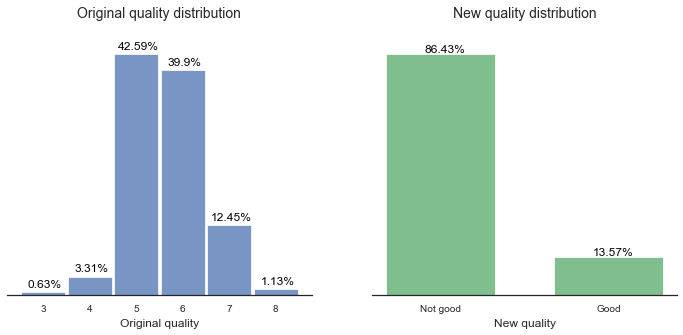

In [10]:
# Create plot object, and plot target feature distribution
pg = plotGraph()
fig1 = plt.figure(figsize=(12,5))
newTDF = data.newDF.groupby('Quality').count().div(data.newDF.shape[0]).mul(100)
oldTDF = data.oldDF.groupby('quality').count().div(data.oldDF.shape[0]).mul(100)
lstDF = [oldTDF, newTDF]
lstTitle = ['Original quality distribution', 'New quality distribution']
lstXlabel = ['Original quality', 'New quality']
lstXticks = [list(oldTDF.index), ['Not good', 'Good']]
lstWidth = [0.95, 0.65]
for i in range(len(lstDF)):
    pg.plotBarText(lstDF[i], fig1.add_subplot(1,2,i+1), lstTitle[i], lstXlabel[i], lstXticks[i], 
                   xLabelFS = 12, plotC = plotColor[i], barW = lstWidth[i], barTxtFS = 12)

* **Correlation matrix**

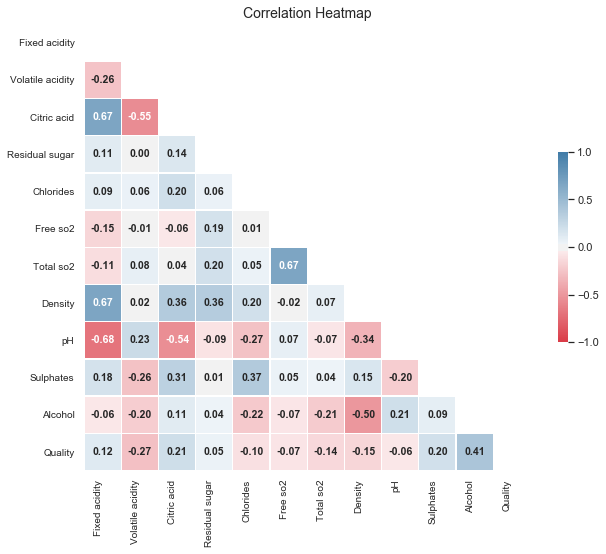

In [11]:
# Plot correlation matrix
pg.plotCorr(data.newDF.corr(), 'Correlation Heatmap', figSize = [10,10], titleFS = 14,
            cmap = CorrCmap, lineW = 0.3, cbarD = {"shrink": .35, "ticks":[-1, -0.5, 0, 0.5,1]},
            annD = {'size': 10.5, 'weight' : 'bold'}, yLim = [1.0425,0.0])
plt.show()

## 3. Exploratory data analysis

* **Features statistics per target label**

In [12]:
# Display the mean summary of the records per target label.
meanDF = data.groupDF('Quality')
meanDF

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free so2,Total so2,Density,pH,Sulphates,Alcohol
Quality,,,,,,,,,,,
0,8.236831,0.547022,0.254407,2.512120,0.089281,16.172214,48.285818,0.996859,3.314616,0.644754,10.251037
1,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049


In [13]:
# Display the STD summary of the records per target label.
stdDF = data.groupDF('Quality', 'std')
stdDF

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free so2,Total so2,Density,pH,Sulphates,Alcohol
Quality,,,,,,,,,,,
0,1.682726,0.176337,0.189665,1.415778,0.049113,10.467685,32.585604,0.001808,0.154135,0.170629,0.969664
1,1.999977,0.144963,0.194438,1.363026,0.028480,10.234615,32.572238,0.002201,0.154478,0.134038,0.998153


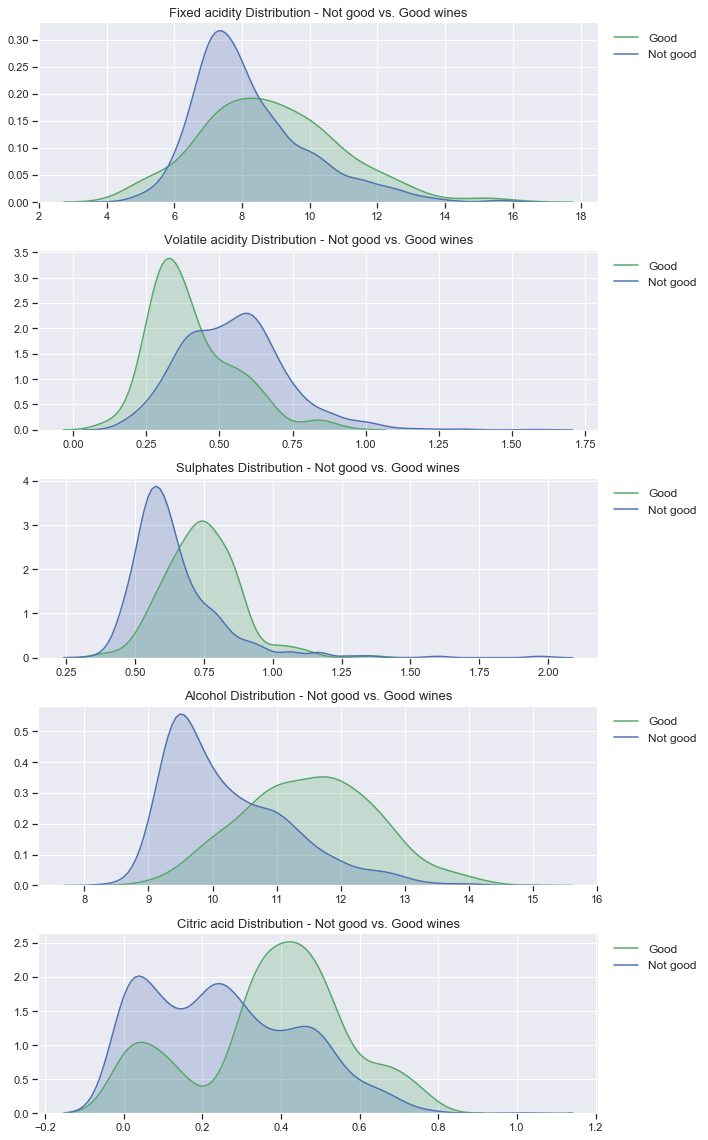

In [14]:
# Plot KDE for important features per target value
fig1 = plt.figure(figsize=(10,16))
pg.setStyle('darkgrid')
lstLbl = ['Good', 'Not good']
lstKDE = ['Fixed acidity','Volatile acidity','Sulphates','Alcohol','Citric acid']
for i in range(len(lstKDE)):
    pg.plotKDE(fig1.add_subplot(5,1,i+1), 'Distribution - Not good vs. Good wines',
               [data.newDF.loc[(data.newDF['Quality'] == 1), lstKDE[i]],
                data.newDF.loc[(data.newDF['Quality'] == 0), lstKDE[i]]], lstKDE[i],
               lstLbl, colors = [plotColor[1], plotColor[0]], legLoc = [1.195,1],
               legFS = 12, titleFS = 13)
plt.show()

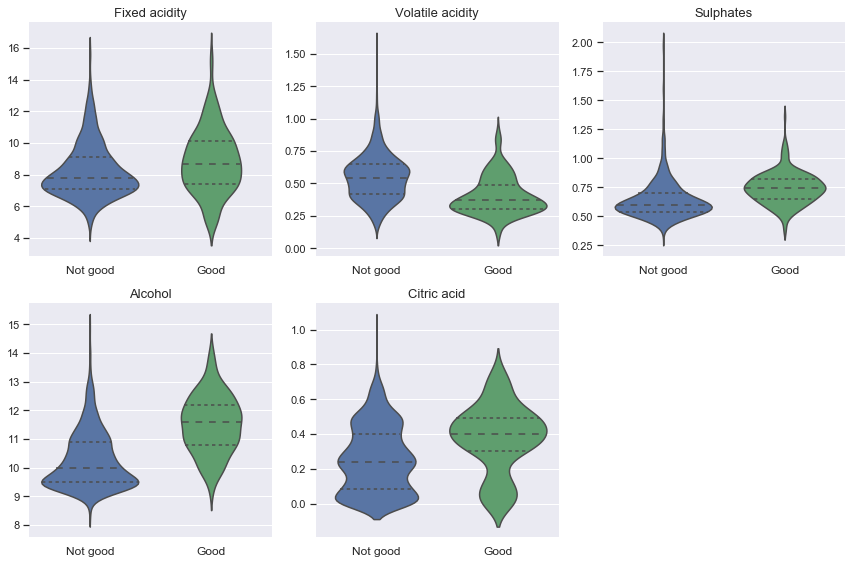

In [15]:
# Plot violins per target value for the same features
fig1 = plt.figure(figsize=(12,8))
for i in range(len(lstKDE)):
    pg.plotViolin(fig1.add_subplot(2,3,i+1), data.newDF['Quality'], 
                  data.newDF[lstKDE[i]], plotColor[0:2], lstKDE[i], 
                  ['Not good','Good'], titleFS = 13, xTicksFS = 12, inner = 'quartile')

* **Correlated features analysis**

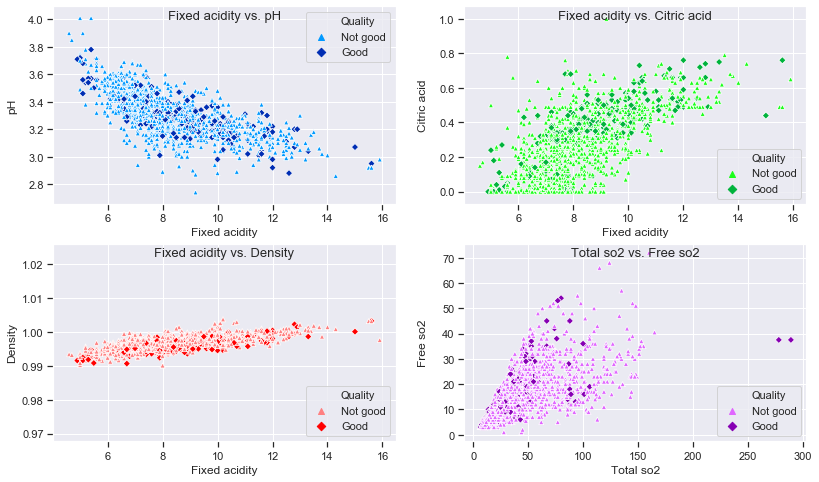

In [16]:
# Plot scatter per target value for the same features
colX = ['Fixed acidity', 'Fixed acidity', 'Fixed acidity', 'Total so2']
colY = ['pH', 'Citric acid', 'Density', 'Free so2']
lstLegLbl = ['Not good', 'Good']
markers = {1: 'D', 0 : '^'}
fig1 = plt.figure(figsize=(13.5,8))
for i in range(len(colX)):
    pg.plotScat(data.newDF, colX[i], colY[i], 'Quality', 'Quality', scatColor[i],
                fig1.add_subplot(2,2,i+1), markers, lstLegLbl, legLoc = 4 if i > 0 else 1)

## 4. Data pre-processing

* **Train/test split, normalization and resample of the data**

In [17]:
# List the features and split in Train/Test 
lstFeatures = list(data.newDF.columns)
lstFeatures.remove('Quality')
data.dataPrep(lstFeatures, 'Quality', 0.3, 'Quality')

Data splitted in train and test datasets

Full dataset shape   -->  (1599, 12)
Train features shape -->  (1119, 11)
Test features shape  -->  (1119,)
Train target shape   -->  (480, 11)
Test target shape    -->  (480,)

Data normalized

Data upsampled

Original shape:  (1119, 11) (1119,)
SMOTE shape:     (1934, 11) (1934,)


## 5. Model development

* **Model baselines**

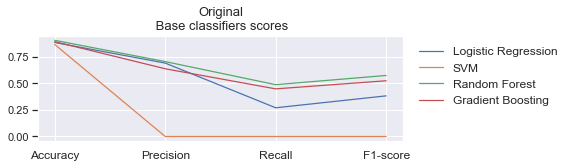

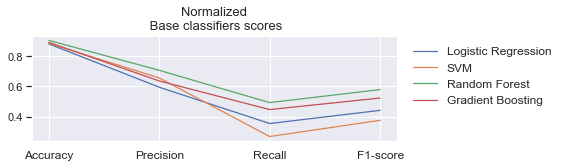

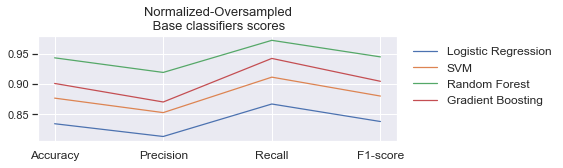

In [18]:
# Create model handler, and check performance per train set
model = modelHandler()
lstCols = ['Score', 'Accuracy', 'Precision', 'Recall', 'F1-score']
lstClf = [model.clfLR, model.clfSVM, model.clfRF, model.clfXGB]
lstClfN = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']
lstScores = ['accuracy', 'precision', 'recall', 'f1']
lstXTrain = [[data.trainX, data.trainY, 'Original\n'], 
             [data.trainX_N, data.trainY, 'Normalized\n'], 
             [data.trainX_NS, data.trainY_NS, 'Normalized-Oversampled\n']]

# Loop with the datasets, do cross_val_score and plot it
for i in range(len(lstXTrain)):
    resDF = model.CVS(lstXTrain[i][0], lstXTrain[i][1], lstClf, lstClfN, 
                      lstScores, lstCols, cv = 8)
    fig1 = plt.figure(figsize=(8,2.5))
    strTitle = '{} Base classifiers scores'.format(lstXTrain[i][2])
    pg.plotCVS(resDF.index, resDF, fig1, strTitle, lstClfN, titleFS = 13, 
               lineW = 1.25, xTicksFS = 12, legLoc = [1.0151,1], legFS = 12)    
    plt.show()

* **Model tunning**

In [19]:
# Tune hyperparameters for all classifiers
dctLR = {'C' : [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5]}
dctSVM = {'C' : [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5],
          'gamma' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1]}
dctRF = {'max_features' : [0.3, 0.4, 0.5],
         'max_depth' : [9,10,11],
         'n_estimators' :[80,90,100]}
dctXGB = {'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.4, 0.5],
           'max_features' : ['auto', 0.2, 0.7],
           'max_depth' : [3, 4, 5, 6],
           'gamma' : [0.005, 0.01, 0.015, 0.02, 0.03]}
parGrid = [dctLR, dctSVM, dctRF, dctXGB]
model.clfRF = RandomForestClassifier(random_state = rndSt)
model.clfXGB = xgb.XGBClassifier(n_estimators = 100,
                                 early_stopping_rounds = 15,
                                 random_state = rndSt)
# Perform tunning process
model.paramTunning(data.trainX_NS, data.trainY_NS, lstClf, lstClfN, 
                   parGrid, score = 'f1')

== Logistic Regression ==

f1 score: 0.8393
Parameters: {'C': 0.01}

== SVM ==

f1 score: 0.9694
Parameters: {'C': 1.5, 'gamma': 1}

== Random Forest ==

f1 score: 0.9349
Parameters: {'max_depth': 11, 'max_features': 0.5, 'n_estimators': 100}

== Gradient Boosting ==

f1 score: 0.9506
Parameters: {'gamma': 0.005, 'learning_rate': 0.5, 'max_depth': 4, 'max_features': 'auto'}

f1 score: 0.9506
Parameters: {'gamma': 0.005, 'learning_rate': 0.5, 'max_depth': 4, 'max_features': 0.2}

f1 score: 0.9506
Parameters: {'gamma': 0.005, 'learning_rate': 0.5, 'max_depth': 4, 'max_features': 0.7}



* **Model validation**

<Figure size 360x288 with 0 Axes>

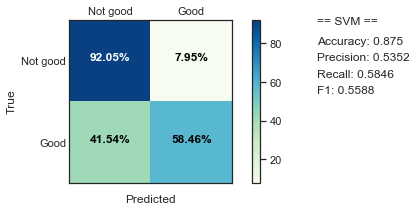

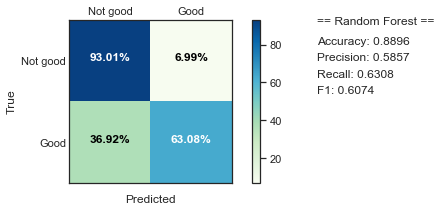

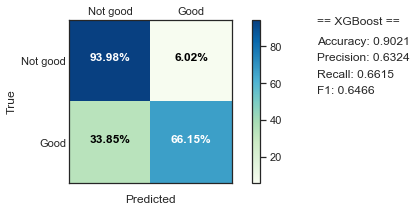

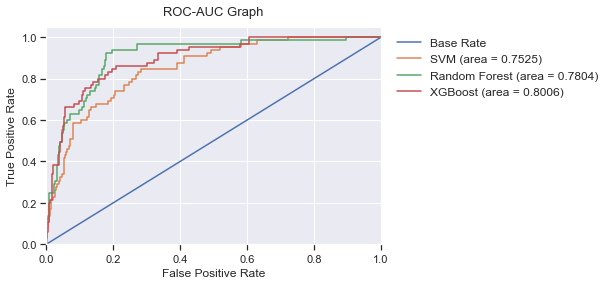

In [20]:
# Update classifiers with best hyperparameters and validate them
model.clfSVM = SVC(C = 1.35, gamma = 0.20, random_state = rndSt, probability=True)
model.clfRF = RandomForestClassifier(n_estimators = 2000, max_features = 0.4,
                                     max_depth = 10, random_state = rndSt)
model.clfXGB = xgb.XGBClassifier(n_estimators = 1000, early_stopping_rounds = 25,
                                 learning_rate = 0.25, max_features = 0.7, gamma = 0.02,
                                 max_Depth = 4, min_samples_leaf = 2, random_state = rndSt)
lstCLF = [model.clfSVM, model.clfRF, model.clfXGB]
lstCLFN = ['SVM', 'Random Forest', 'XGBoost']
lstLabels = ['Not good','Good']
figROC = plt.figure(figsize=(5,4))
model.modelValidation(lstCLF, lstCLFN, lstLabels, figROC)

* **Feature importance and predictions**

Fitting model to train data...


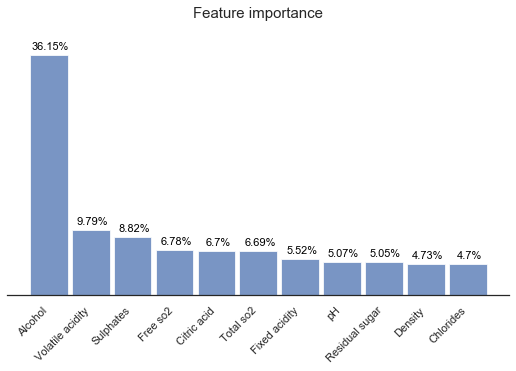


Predicting with test data...
Predictions exported


In [21]:
# Fit, plot feature importance, predict and export to an excel file
model.bestM = model.clfXGB
model.bestCLF(model.bestM, plt.figure(figsize=[9,5]))